In [1]:
import os
import torch
import numpy as np
from pprint import pprint
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import torch.nn.functional as F

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig,BasicPipelineConfig
from conditional_rate_matching.data.states_dataloaders_config import StatesDataloaderConfig
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders_crm
from conditional_rate_matching.models.trainers.call_all_trainers import call_trainer

from conditional_rate_matching.configs.config_files import ExperimentFiles

from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMTrainerConfig
from conditional_rate_matching.configs.configs_classes.config_crm import OptimalTransportSamplerConfig

from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer
from conditional_rate_matching.utils.histograms import (
    categorical_histogram_dataloader,
    categorical_counts_per_path,
    get_conditional_histograms_paths,
    plot_time_series_histograms
)
from conditional_rate_matching.models.trainers.crm_trainer import CRMDataloder
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import ConstantThermostatConfig,LogThermostatConfig


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/tqdm-4.66.1-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
config = CRMConfig()
device = 'cpu'
vocab_size = 6
dimensions = 2
gamma=1./vocab_size
config.data0 = StatesDataloaderConfig(dimensions=1,vocab_size=vocab_size)
config.data1 = StatesDataloaderConfig(dirichlet_alpha=0.025,
                                      total_data_size=500,
                                      dimensions=dimensions,
                                      vocab_size=vocab_size,
                                      test_size=0.1)

config.pipeline = BasicPipelineConfig(number_of_steps=100)
config.thermostat = ConstantThermostatConfig(gamma=gamma)
config.trainer = CRMTrainerConfig(number_of_epochs=100,learning_rate=1e-3, device=device)
config.optimal_transport = OptimalTransportSamplerConfig(name="uniform", cost=None)

crm = CRM(config=config)

# Train Model

In [21]:
experiment_files = ExperimentFiles(experiment_name="crm",
                                   experiment_type="tutorial",
                                   experiment_indentifier=None)
crm_trainer = CRMTrainer(config, experiment_files) # TRAINER CREATES MODEL FROM CONFIG FILE
results_, all_metrics = crm_trainer.train()

# ==================================================
# START OF TRAINING 
# ==================================================
# Current Model ************************************
tutorial
crm
None
# ==================================================
# Number of Epochs 100
# ==================================================


Epoch 100, Loss: 0.0002: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


In [22]:
crm = CRM(experiment_dir=experiment_files.experiment_dir)
crm.config.pipeline.number_of_steps = 1000
sample_x = crm.pipeline(sample_size=1000,train=False)


1000it [00:01, 984.26it/s]
1000it [00:00, 1079.20it/s]
1000it [00:01, 920.06it/s]
1000it [00:01, 869.25it/s]
1000it [00:01, 963.38it/s]
1000it [00:01, 957.52it/s]
1000it [00:01, 886.63it/s]
1000it [00:00, 1132.54it/s]


In [23]:
x_f, x_path, t_path = crm.pipeline(sample_size=1000,return_path=True)


1000it [00:01, 923.36it/s]
1000it [00:00, 1017.23it/s]
1000it [00:00, 1170.77it/s]
1000it [00:00, 1070.28it/s]
1000it [00:01, 913.41it/s]
1000it [00:00, 1072.11it/s]
1000it [00:01, 779.68it/s]
1000it [00:01, 834.73it/s]


In [16]:
# dimensions = config.data1.dimensions
# vocab_size = config.data1.vocab_size

# x_f, x_path, t_path = crm.pipeline(sample_size=500,return_path=True)
histogram_0 = categorical_histogram_dataloader(crm.dataloader_0,dimensions=dimensions,number_of_classes=vocab_size)
histogram_1 = categorical_histogram_dataloader(crm.dataloader_1,dimensions=dimensions,number_of_classes=vocab_size)
histograms_paths = categorical_counts_per_path(x_path.cpu(),dimensions=3,vocab_size=vocab_size,normalize=True)
conditional_histograms_paths = get_conditional_histograms_paths(crm,t_path.cpu(),num_timesteps_to_plot=10)

### uniform

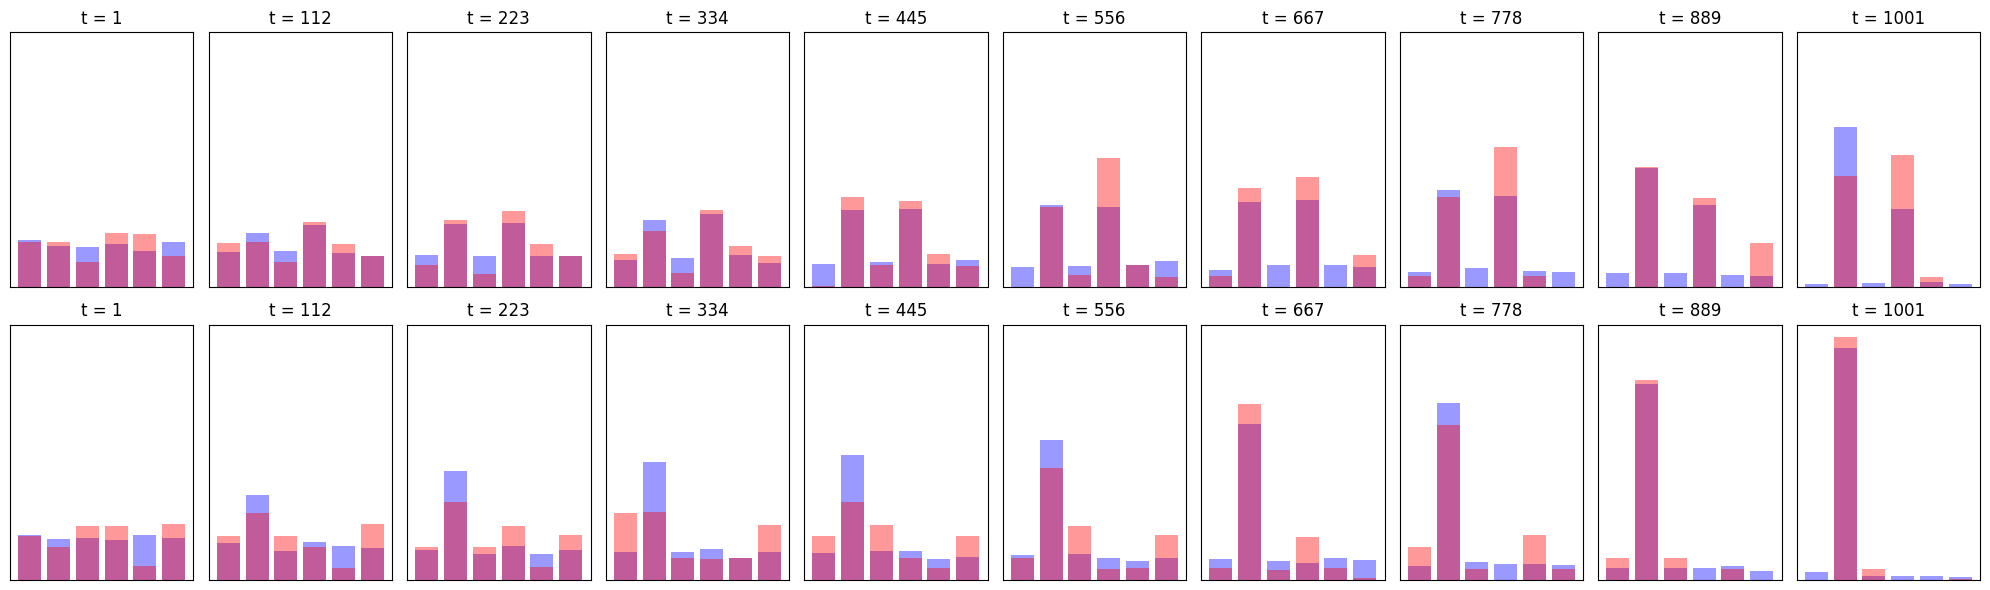

In [24]:
indices = plot_time_series_histograms(histograms_paths, conditional_histograms_paths, 10)

### Log-cost

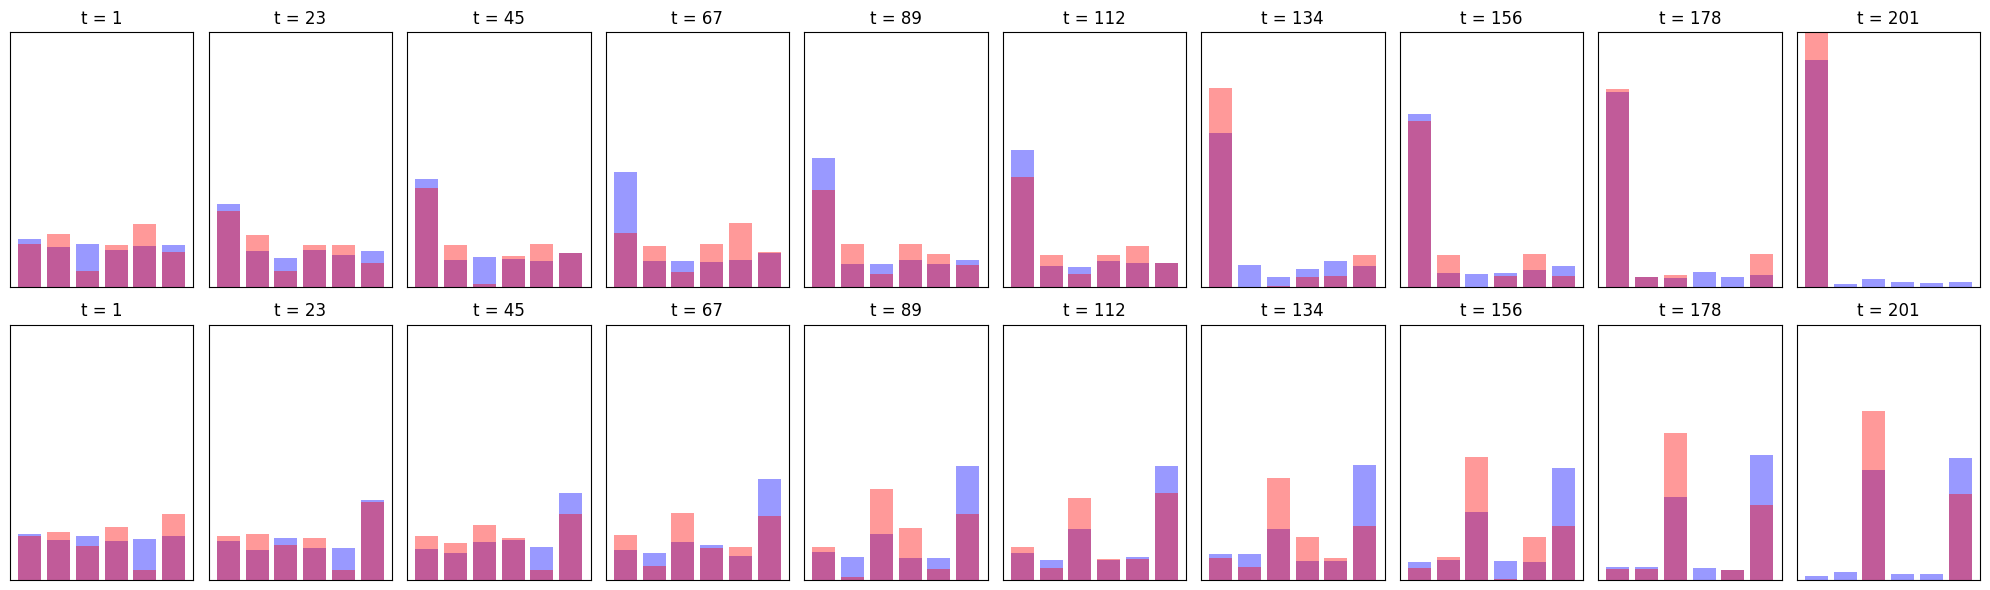

In [17]:
indices = plot_time_series_histograms(histograms_paths, conditional_histograms_paths, 10)

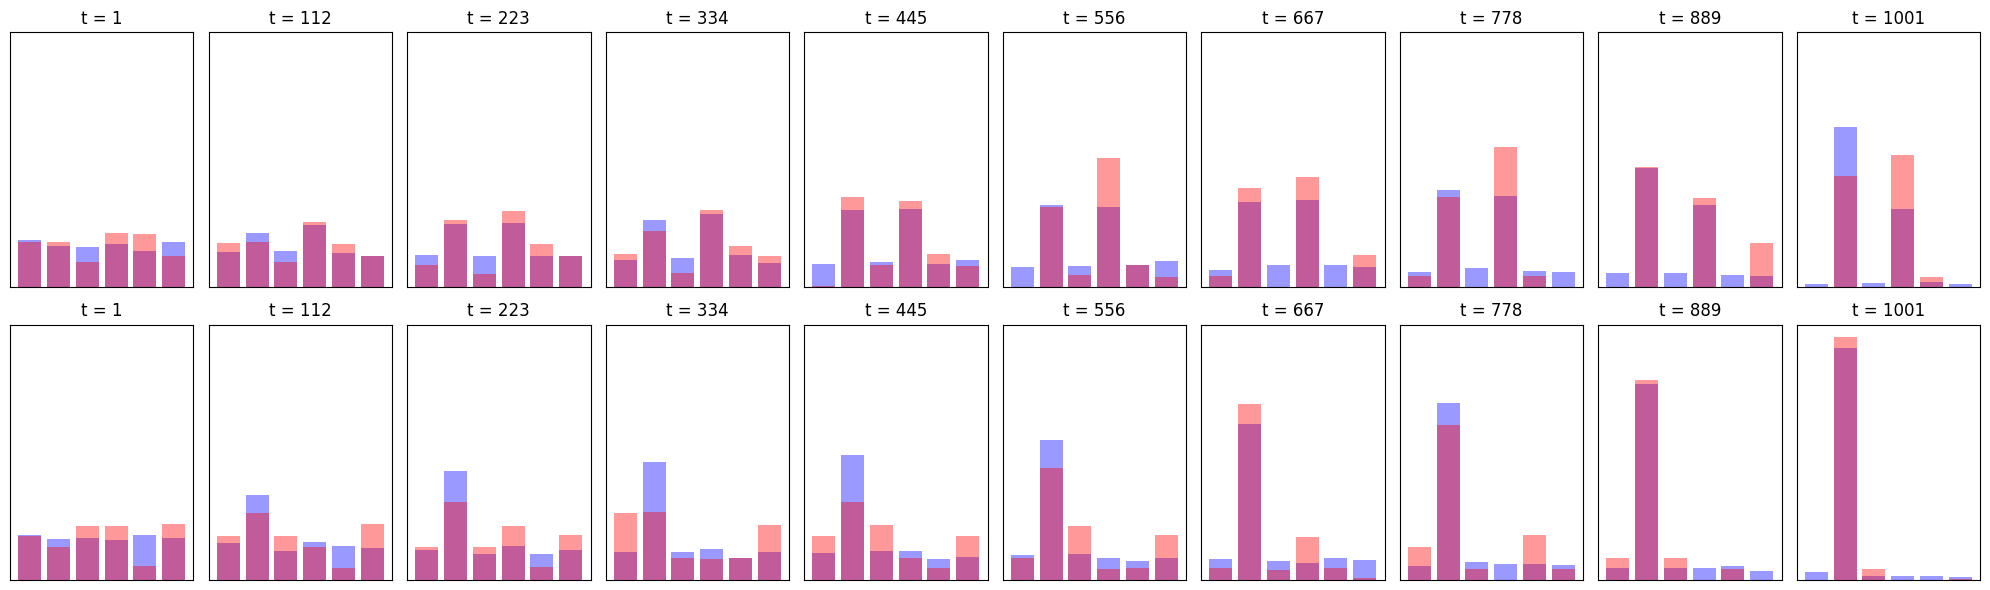

In [17]:
indices = plot_time_series_histograms(histograms_paths, conditional_histograms_paths, 10)

In [9]:
databatch0 = next(crm.dataloader_0.train().__iter__())
databatch1 = next(crm.dataloader_1.train().__iter__())

In [10]:
databatch0 = next(crm.dataloader_0.train().__iter__())
databatch1 = next(crm.dataloader_1.train().__iter__())
crm.sample_pair(databatch0,databatch1,torch.device("cpu"))

(tensor([[4., 0.],
         [0., 5.],
         [4., 3.],
         [0., 3.],
         [4., 5.],
         [4., 4.],
         [5., 4.],
         [1., 1.],
         [5., 4.],
         [3., 2.],
         [0., 3.],
         [3., 1.],
         [2., 0.],
         [4., 5.],
         [2., 4.],
         [3., 0.],
         [0., 1.],
         [5., 2.],
         [2., 0.],
         [0., 3.],
         [3., 2.],
         [3., 4.],
         [4., 3.]]),
 tensor([[3., 1.],
         [1., 4.],
         [3., 2.],
         [3., 2.],
         [3., 2.],
         [3., 2.],
         [3., 2.],
         [3., 1.],
         [3., 2.],
         [3., 1.],
         [3., 2.],
         [3., 1.],
         [3., 1.],
         [3., 2.],
         [3., 2.],
         [3., 1.],
         [1., 1.],
         [3., 2.],
         [3., 1.],
         [3., 2.],
         [3., 1.],
         [3., 2.],
         [3., 2.]]))

# Calculate Metrics Again

In [ ]:
from conditional_rate_matching.models.metrics.metrics_utils import log_metrics, MetricsAvaliable
metrics_avaliable = MetricsAvaliable()

In [ ]:
# number of samples requiered to calculate the test 
# this number should not be that big as the sample and paths are stored to perform the statistics
crm.config.trainer.max_test_size = crm.config.data1.test_size 
crm.config.pipeline.number_of_steps = 100
crm.config.data1.test_size 

In [ ]:
metric_string = metrics_avaliable.mse_histograms
test_statistics = []
for i in range(10):
    metrics = log_metrics(crm,all_metrics={},metrics_to_log={metric_string})
    print(metrics)
    test_statistics.append(metrics["mse_marginal_histograms"])
test_statistics = np.asarray(test_statistics)

In [2]:
import os
import torch
import numpy as np
from pprint import pprint
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import torch.nn.functional as F

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig,BasicPipelineConfig
from conditional_rate_matching.data.states_dataloaders_config import StatesDataloaderConfig
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders_crm
from conditional_rate_matching.models.trainers.call_all_trainers import call_trainer

from conditional_rate_matching.configs.config_files import ExperimentFiles

from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMTrainerConfig
from conditional_rate_matching.configs.configs_classes.config_crm import OptimalTransportSamplerConfig

from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer
from conditional_rate_matching.utils.histograms import (
    categorical_histogram_dataloader,
    categorical_counts_per_path,
    get_conditional_histograms_paths,
    plot_time_series_histograms
)
from conditional_rate_matching.models.trainers.crm_trainer import CRMDataloder
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import ConstantThermostatConfig,LogThermostatConfig


In [ ]:
from torch.nn import functional as F
from matplotlib import pyplot as plt
from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer,CRMDataloder

device = 'cpu'
vocab_size = 6
dimensions = 2
gamma=1./vocab_size
batch_size = 2

config = CRMConfig()
config.data0 = StatesDataloaderConfig(dimensions=1,vocab_size=vocab_size, batch_size= batch_size)
config.data1 = StatesDataloaderConfig(dirichlet_alpha=0.025,
                                      total_data_size=5000,
                                      dimensions=dimensions,
                                      vocab_size=vocab_size,
                                      batch_size= batch_size,
                                      test_size=0.1)

config.pipeline = BasicPipelineConfig(number_of_steps=100)
config.thermostat = ConstantThermostatConfig(gamma=gamma)
config.trainer = CRMTrainerConfig(number_of_epochs=100,learning_rate=1e-3, device=device)
config.optimal_transport = OptimalTransportSamplerConfig(name="uniform", cost=None)

crm = CRM(config=config)

crm_dataloader = CRMDataloder(crm.dataloader_0,crm.dataloader_1)
histogram_0 = categorical_histogram_dataloader(crm.dataloader_0,dimensions=dimensions,number_of_classes=vocab_size)
histogram_1 = categorical_histogram_dataloader(crm.dataloader_1,dimensions=dimensions,number_of_classes=vocab_size)

sample_size = 0
transport_histogram_0 = torch.zeros(dimensions,vocab_size)
transport_histogram_1 = torch.zeros(dimensions,vocab_size)
for databatch  in crm_dataloader.train():
    databatch0 = databatch[0]
    databatch1 = databatch[1]
    print('d', databatch0, databatch1)
    x_1,x_0 = crm.sample_pair(databatch1,databatch0,torch.device("cpu"))
    print("x", x_0, x_1)

    batch_size = x_1.shape[0]
    transport_histogram_0 += F.one_hot(x_0.long(),num_classes=vocab_size).sum(axis=0)
    transport_histogram_1 += F.one_hot(x_1.long(),num_classes=vocab_size).sum(axis=0)
    sample_size += batch_size

transport_histogram_0 = transport_histogram_0/float(sample_size)
transport_histogram_1 = transport_histogram_1/float(sample_size)


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,2))
ax[0].bar(range(vocab_size), transport_histogram_0[0].numpy(), color='blue',alpha=0.4,label="transport")
ax[0].bar(range(vocab_size), histogram_0[0].numpy(), color='red',alpha=0.4,label="free data")
ax[1].bar(range(vocab_size), transport_histogram_1[0].numpy(), color='blue',alpha=0.4,label="transport")
ax[1].bar(range(vocab_size), histogram_1[0].numpy(), color='red',alpha=0.4,label="free data")
plt.legend(loc="best")

d [tensor([[5., 1.],
        [2., 4.]])] [tensor([[3., 2.],
        [3., 2.]])]


OT regularizer for Schrodinger Plan 0.5208807238549931
d [tensor([[2., 4.],
        [6., 2.]])] [tensor([[5., 9.],
        [9., 9.]])]
x tensor([[6., 2.],
        [6., 2.]]) tensor([[5., 9.],
        [9., 9.]])
d [tensor([[3., 4.],
        [6., 1.]])] [tensor([[9., 9.],
        [5., 9.]])]
x tensor([[6., 1.],
        [3., 4.]]) tensor([[9., 9.],
        [5., 9.]])
d [tensor([[8., 3.],
        [4., 0.]])] [tensor([[5., 9.],
        [9., 9.]])]
x tensor([[8., 3.],
        [8., 3.]]) tensor([[9., 9.],
        [5., 9.]])
d [tensor([[3., 8.],
        [5., 8.]])] [tensor([[9., 9.],
        [9., 9.]])]
x tensor([[5., 8.],
        [5., 8.]]) tensor([[9., 9.],
        [9., 9.]])
d [tensor([[7., 5.],
        [8., 5.]])] [tensor([[9., 9.],
        [5., 9.]])]
x tensor([[8., 5.],
        [7., 5.]]) tensor([[9., 9.],
        [5., 9.]])
d [tensor([[5., 0.],
        [8., 1.]])] [tensor([[5., 9.],
        [9., 9.]])]
x tensor([[8., 1.],
        [8., 1.]]) tensor([[9., 9.],
        [5., 9.]])
d [tensor

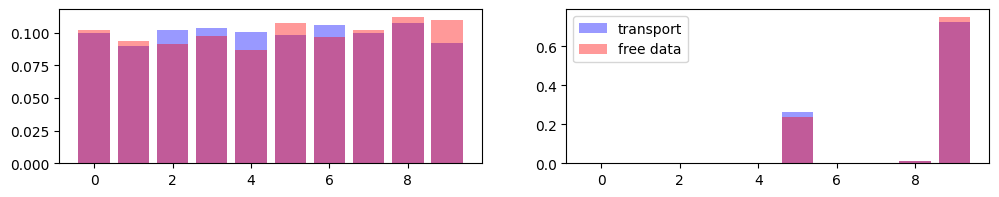

In [5]:
from torch.nn import functional as F
from matplotlib import pyplot as plt
from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer,CRMDataloder

device = 'cpu'
vocab_size = 10
dimensions = 2
gamma=1./vocab_size
batch_size = 2

config = CRMConfig()
config.data0 = StatesDataloaderConfig(dimensions=1,vocab_size=vocab_size, batch_size= batch_size)
config.data1 = StatesDataloaderConfig(dirichlet_alpha=0.025,
                                      total_data_size=5000,
                                      dimensions=dimensions,
                                      vocab_size=vocab_size,
                                      batch_size= batch_size,
                                      test_size=0.1)

config.pipeline = BasicPipelineConfig(number_of_steps=100)
config.thermostat = ConstantThermostatConfig(gamma=gamma)
config.trainer = CRMTrainerConfig(number_of_epochs=100,learning_rate=1e-3, device=device)
config.optimal_transport = OptimalTransportSamplerConfig(name="OTPlanSampler", cost='log')

crm = CRM(config=config)

crm_dataloader = CRMDataloder(crm.dataloader_0,crm.dataloader_1)
histogram_0 = categorical_histogram_dataloader(crm.dataloader_0,dimensions=dimensions,number_of_classes=vocab_size)
histogram_1 = categorical_histogram_dataloader(crm.dataloader_1,dimensions=dimensions,number_of_classes=vocab_size)

sample_size = 0
transport_histogram_0 = torch.zeros(dimensions,vocab_size)
transport_histogram_1 = torch.zeros(dimensions,vocab_size)
for databatch  in crm_dataloader.train():
    databatch0 = databatch[0]
    databatch1 = databatch[1]
    print('d', databatch0, databatch1)
    x_1,x_0 = crm.sample_pair(databatch1,databatch0,torch.device("cpu"))
    print("x", x_0, x_1)

    batch_size = x_1.shape[0]
    transport_histogram_0 += F.one_hot(x_0.long(),num_classes=vocab_size).sum(axis=0)
    transport_histogram_1 += F.one_hot(x_1.long(),num_classes=vocab_size).sum(axis=0)
    sample_size += batch_size

transport_histogram_0 = transport_histogram_0/float(sample_size)
transport_histogram_1 = transport_histogram_1/float(sample_size)


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,2))
ax[0].bar(range(vocab_size), transport_histogram_0[0].numpy(), color='blue',alpha=0.4,label="transport")
ax[0].bar(range(vocab_size), histogram_0[0].numpy(), color='red',alpha=0.4,label="free data")
ax[1].bar(range(vocab_size), transport_histogram_1[0].numpy(), color='blue',alpha=0.4,label="transport")
ax[1].bar(range(vocab_size), histogram_1[0].numpy(), color='red',alpha=0.4,label="free data")
plt.legend(loc="best")